# 2.1 - Depth Estimation

_Tiffany Wang - 260684152_

In [2]:
import numpy as np
from struct import *
import re
from matplotlib import pyplot as plt
import cv2
import math

In [3]:
''' Provided function for reading a pfm file '''
def read_pfm(file):
    # Adopted from https://stackoverflow.com/questions/37073108/how-to-read-pfm-files-provided-with-middlebury-dataset?rq=1
    with open(file, "rb") as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

        # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.flipud(np.array(img).reshape(height, width))
        img[img==np.inf] = 0
    return img

In [4]:
def plot_figs(imgs, titles=None, max_col=4):
    """
    Plots list of images in a grid. 
    -----
    args imgs: list of images.
    args titles: list of titles, defaults to None.
    args max_col: number of column in the grid, defaults to 4.
    -----
    return: None.
    """
    n = len(imgs)
    
    # Each plot can hold up to 8 images.
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    sets = math.ceil(n / fig_per_set)
    
    for s in range(sets):
        # starting index of your set
        start = s * fig_per_set
        
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, n) - start
        nb_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i], cmap='gray')
    plt.show()

In [5]:
def disparity(imgL, imgR, numDisparities, blockSize):
    """
    Computes disparity between two images. 
    -----
    args imgL: Left image. 
    args imgR: Right image. 
    args numDisparities: Number of disparities used to compute the stereo disparity. 
    args blockSize: Block size used to compute the stereo disparity.
    -----
    returns: disparity between imgL and imgR
    """
    stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)
    disparity = stereo.compute(imgL,imgR)
    return disparity

In [6]:
def mse(img1, img2):
    """
    Computes MSE between two images.
    -----
    args img1: first image. 
    args img2: second image. 
    -----
    return: mse, error_map
    """
    err_map = (img1  - img2) ** 2 
    err = err_map.mean()
    return err, err_map

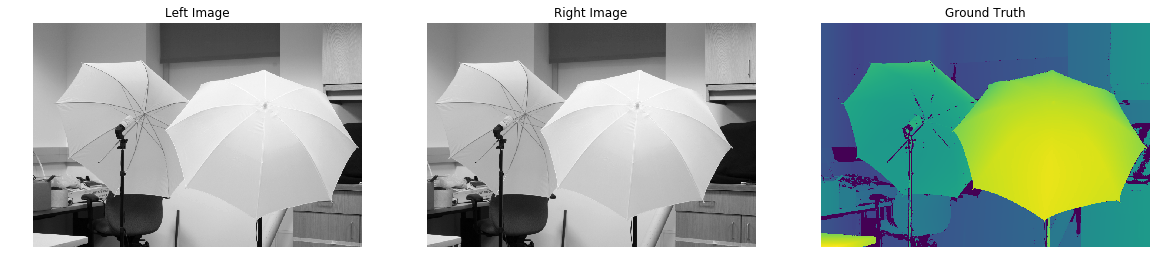

In [8]:
# load and scale left and right images 
imgL = cv2.imread('im0.png', cv2.IMREAD_GRAYSCALE)
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)

imgR = cv2.imread('im1.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)


# load and scale ground truth image
ground_truth = read_pfm('disp0.pfm')
ground_truth = cv2.resize(ground_truth, None, fx=0.3, fy=0.3)

# display images 
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title("Left Image")
plt.imshow(imgL, cmap='gray'), plt.axis('off')

plt.subplot(132)
plt.title("Right Image")
plt.imshow(imgR, cmap='gray'), plt.axis('off')

plt.subplot(133)
plt.title("Ground Truth")
plt.imshow(ground_truth), plt.axis('off')

plt.show()

###### Estimate depth using the stereo image pair. Show the results of varying the following parameters: 
<ul>
    <li>blockSize 2 [5; 9; 15] </li>
    <li>numDisparities 2 [16; 32; 48] </li>
</ul>

##### You will have a total of 9 depth-maps, each corresponding to one combination of blocksize and numDisparities.

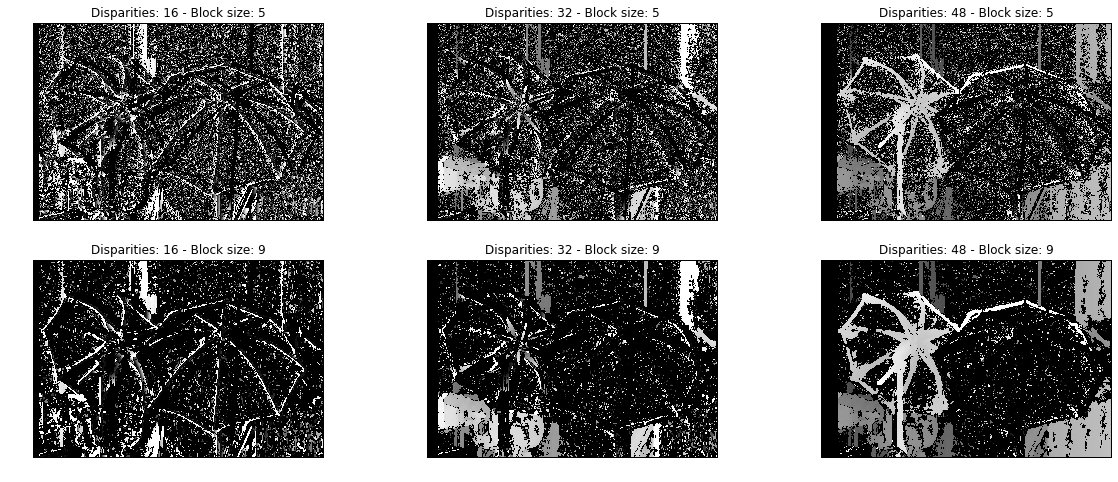

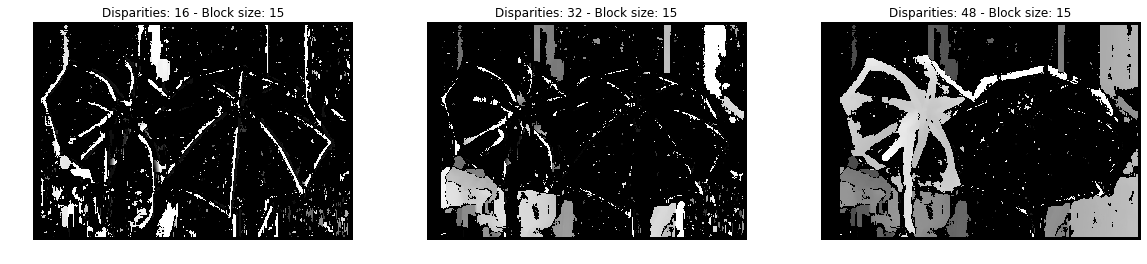

In [68]:
# Estimate depth for each permutation
blockSize = [5, 9, 15]
numDisparities = [16, 32, 48]

depth_maps = []
titles = []
for b in blockSize:
    for n in numDisparities:
        depth_maps.append(disparity(imgL, imgR, n, b))
        titles.append("Disparities: {} - Block size: {}".format(n, b))

# Plot the results 
plot_figs(depth_maps, titles, 3)

###### For each depth-map, compute the pixel-wise squared diﬀerence error with respect to the ground-truth.

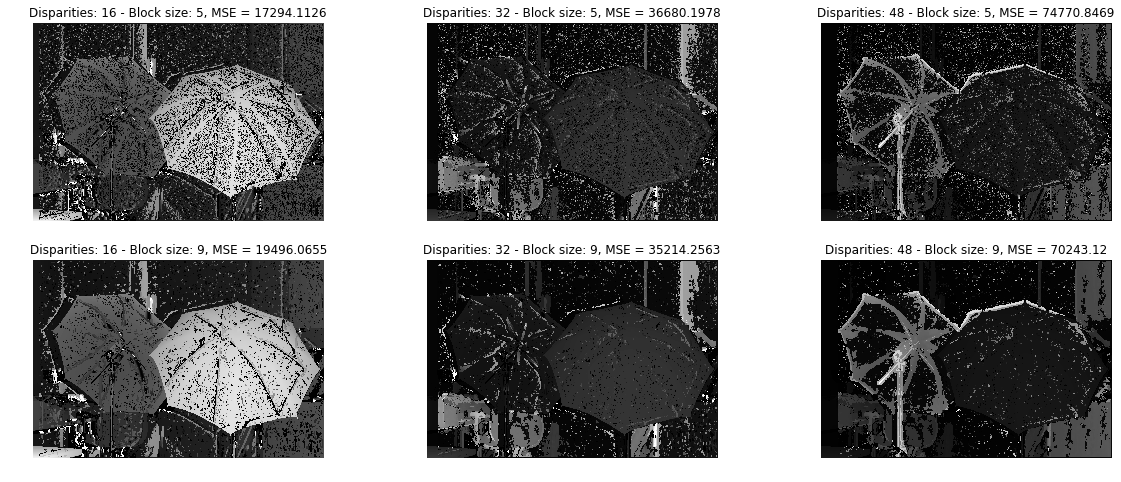

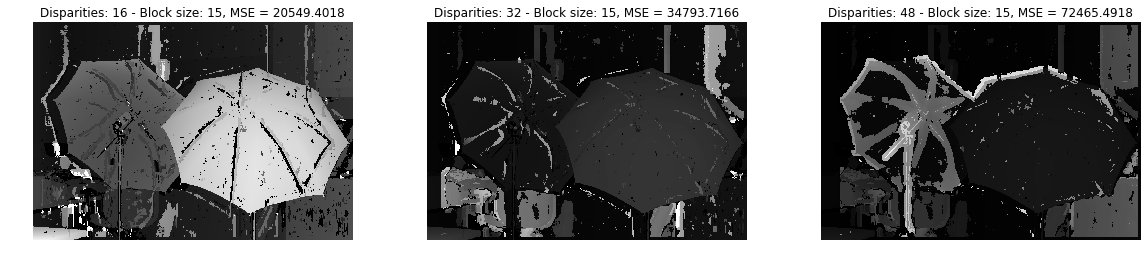

In [70]:
# compute pixel-wise MSE
err_maps = []
mse_titles = []
for i in range(len(depth_maps)):
    err, err_map = mse(ground_truth, depth_maps[i])
    err_maps.append((ground_truth - depth_maps[i]) ** 2)
    mse_titles.append("{}, MSE = {}".format(titles[i], round(err, 4)))

# plot with depth maps
plot_figs(err_maps, mse_titles, 3)

###### Comment on the error-maps for each combination of parameters. Specifically, mention the eﬀects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.

In general, the performance of the depth estimation increases with the number of disparity and the block size. Higher disparity allow better estimation on small depth variations, and larger block sizes render more generalized results. However, the overall MSE increases with the number of disparity and with the block size. 
At low disparity and block sizes, each pixel's error is generally small, yet there are a lot of errors. Nevertheless, when the parameter numbers are high, there are small quantities of errors, but the errors are very large. 

Small block sizes work better with high texture regions, as it is capable of capturing the different variations of depth within a small region. However, larger block sizes work better with low texture regions, for they generalize better and are less subject to noise. 

Edge detection is rather invariant to change of disparity number and block size. 